# Applying classic CNN models: NN vs LeNet vs AlexNet

In this practice you will apply different Neural Networks models to solve a set of problems:
1. First, we start with lego bricks and try to classify them with using basic models
2. Next, we will apply same models for FashionMNIST dataset, it contains 60K samples of 10 classes
3. Then we will use higher-dimension pictures and will see whether thee techniques still works



## Part I: Lego bricks

As for beginning, lets follow the already known example - Lego bricks, brought by Linux Academy (its not exist anymore though :( ). And compare their model to some classic models that you will build: LeNet & AlexNet.


### Task 1.1 - Neural Network (MLP)

**Task: Use Lego bricks dataset and model to classify samples**


Original Notebook: [https://github.com/linuxacademy/content-aws-mls-c01/blob/master/MXNet-Basic-Classification/MXNet_Basic_Classification.ipynb](https://github.com/linuxacademy/content-aws-mls-c01/blob/master/MXNet-Basic-Classification/MXNet_Basic_Classification.ipynb)

In [5]:
import torch
from torch import nn
import torch.optim as optim

import pickle
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

In [6]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [7]:
# Open the files:
train_fh = open('lego-train.pickle', 'rb')
test_fh = open('lego-test.pickle', 'rb')

# Use pickle to load files into runtime objects:
train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

# train_data -> [] of tuples: (ndarray, uint8 label) 

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

train_data_X = [img for (img, _) in train_data]
train_data_y = [lbl for (_, lbl) in train_data]

test_data_X = [img for (img, _) in test_data]
test_data_y = [lbl for (_, lbl) in test_data]

img_transforms = transforms.Compose([
#    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

def get_dataset(X, y):
    tensor_x = torch.Tensor(X) # transform to torch tensor
    tensor_x = img_transforms(tensor_x)
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x, tensor_y) # create your datset
    return dataset

train_dataset = get_dataset(train_data_X, train_data_y)
test_dataset = get_dataset(test_data_X, test_data_y)


C:\Users\Faste\AppData\Local\Temp\ipykernel_5180\3339772338.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  tensor_x = torch.Tensor(X) # transform to torch tensor


In [9]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']


Original shape is (48, 48, 1)


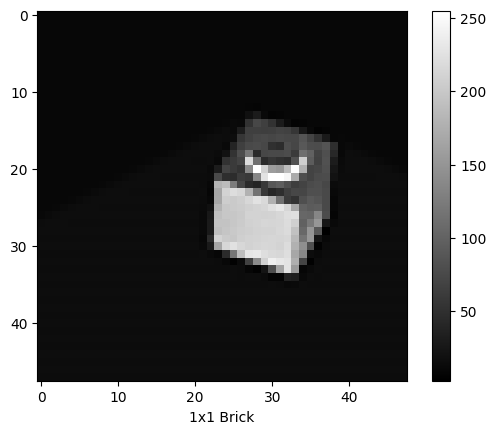

In [ ]:
print("Original shape is", train_data_X[0].shape)

image = train_data_X[0]
labelIndex = train_data_y[0]

plt.figure()
plt.imshow(image, cmap="gray")
plt.colorbar()
plt.xlabel(class_names[labelIndex])
plt.show()


In [18]:
# Define a neural network as per the original lab
def build_NN():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    net = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(48*48, 128),
        torch.nn.Sigmoid(),
        torch.nn.Linear(128, 64),
        torch.nn.Sigmoid(),
        torch.nn.Linear(64, 10)
    )
    
    net.apply(init_weights)
    
    return net

In [19]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                # batch x [48, 48, 1] -> batch x [1, 48, 48]
                inputs = inputs.permute(0, 3, 1, 2).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history


In [20]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [21]:
net = build_NN()
print(net)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=64, out_features=10, bias=True)
)


In [22]:
# prepare training
BATCH_SIZE = 32
EPOCHS = 200
LR = 0.001

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

hist = train(net, train_dataloader, device, EPOCHS, LR)

Epoch: 199, Batch: 14, Loss: 12.27, Acc: 1.00: 100%|██████████| 3000/3000 [00:05<00:00, 596.48it/s]


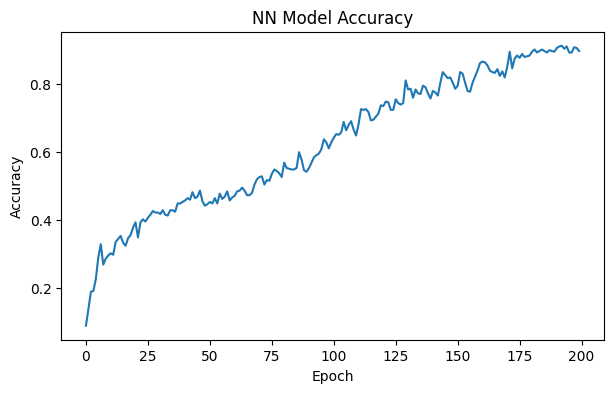

In [23]:
print_history(hist, "NN Model Accuracy")

#### Hyper-params tuning
https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html  
https://stackoverflow.com/questions/44260217/hyperparameter-optimization-for-pytorch-model


In [24]:
def evaluate_acc(net, test_loader, device=device):

    total = 0
    correct = 0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    acc = correct/total
    return acc

In [25]:
import ray
from ray import tune

def hyper_opt_train_nn(config):
    
    net = build_NN()
    # print(net)
    
    # prepare training
    BATCH_SIZE = config["batch_size"]
    EPOCHS = config["epochs"]
    LR = config["lr"]

    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
    train(net, train_dataloader, device, EPOCHS, LR)
    
    test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)
    acc = evaluate_acc(net, test_dataloader)
    
    tune.report({"mean_accuracy": acc})
    


In [26]:
from ray.tune import CLIReporter
from ray.train.torch import TorchTrainer

ray.init(runtime_env={"env_vars": {"RAY_AIR_NEW_OUTPUT": "0"}}, ignore_reinit_error=True)

config = {
    "lr": tune.grid_search([0.001, 0.005, 0.01, 0.1]),
    "batch_size": tune.choice([8, 16, 32, 64]),
    "epochs": tune.grid_search([10, 50, 100, 200]),
}

reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["mean_accuracy"])

analysis = tune.run(
    hyper_opt_train_nn, 
    config=config,
    progress_reporter=reporter)

print("Best config: ", analysis.get_best_config(metric="mean_accuracy", mode='max'))

# Get a dataframe for analyzing trial results.
df = analysis.dataframe()

2025-11-14 19:29:01,593	INFO worker.py:2012 -- Started a local Ray instance.
c:\Python\lib\site-packages\ray\_private\worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
2025-11-14 19:29:02,771	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-11-14 19:29:04 (running for 00:00:01.38)
Using FIFO scheduling algorithm.
Logical resource usage: 0/12 CPUs, 0/0 GPUs
Result logdir: C:/Users/Faste/AppData/Local/Temp/ray/session_2025-11-14_19-28-58_519024_5180/artifacts/2025-11-14_19-29-02/hyper_opt_train_nn_2025-11-14_19-29-02/driver_artifacts
Number of trials: 16/16 (16 PENDING)
+--------------------------------+----------+-------+--------------+----------+-------+
| Trial name                     | status   | loc   |   batch_size |   epochs |    lr |
|--------------------------------+----------+-------+--------------+----------+-------|
| hyper_opt_train_nn_08003_00000 | PENDING  |       |           32 |       10 | 0.001 |
| hyper_opt_train_nn_08003_00001 | PENDING  |       |           16 |       50 | 0.001 |
| hyper_opt_train_nn_08003_00002 | PENDING  |       |           64 |      100 | 0.001 |
| hyper_opt_train_nn_08003_00003 | PENDING  |       |            8 |      200 | 0.001 |
| hyper_opt_train_

Epoch: 0, Batch:  5, Loss: 15.25, Acc: 0.03:   1%|          | 5/750 [00:00<00:02, 293.42it/s]


Trial name,mean_accuracy
hyper_opt_train_nn_08003_00000,0.306667
hyper_opt_train_nn_08003_00001,0.473333
hyper_opt_train_nn_08003_00002,0.58
hyper_opt_train_nn_08003_00003,0.273333
hyper_opt_train_nn_08003_00004,0.206667
hyper_opt_train_nn_08003_00005,0.113333
hyper_opt_train_nn_08003_00006,0.126667
hyper_opt_train_nn_08003_00007,0.1
hyper_opt_train_nn_08003_00008,0.22
hyper_opt_train_nn_08003_00009,0.22


Epoch: 9, Batch: 28, Loss: 65.00, Acc: 0.67: 100%|██████████| 290/290 [00:00<00:00, 369.41it/s]


== Status ==
Current time: 2025-11-14 19:29:14 (running for 00:00:11.48)
Using FIFO scheduling algorithm.
Logical resource usage: 10.0/12 CPUs, 0/0 GPUs
Result logdir: C:/Users/Faste/AppData/Local/Temp/ray/session_2025-11-14_19-28-58_519024_5180/artifacts/2025-11-14_19-29-02/hyper_opt_train_nn_2025-11-14_19-29-02/driver_artifacts
Number of trials: 16/16 (4 PENDING, 10 RUNNING, 2 TERMINATED)
+--------------------------------+------------+-----------------+--------------+----------+-------+-----------------+
| Trial name                     | status     | loc             |   batch_size |   epochs |    lr |   mean_accuracy |
|--------------------------------+------------+-----------------+--------------+----------+-------+-----------------|
| hyper_opt_train_nn_08003_00001 | RUNNING    | 127.0.0.1:4196  |           16 |       50 | 0.001 |                 |
| hyper_opt_train_nn_08003_00002 | RUNNING    | 127.0.0.1:18412 |           64 |      100 | 0.001 |                 |
| hyper_opt_trai

Epoch: 24, Batch: 17, Loss: 41.65, Acc: 0.00:  49%|████▊     | 1385/2850 [00:03<00:03, 487.85it/s] [repeated 3x across cluster]


== Status ==
Current time: 2025-11-14 19:29:19 (running for 00:00:16.48)
Using FIFO scheduling algorithm.
Logical resource usage: 6.0/12 CPUs, 0/0 GPUs
Result logdir: C:/Users/Faste/AppData/Local/Temp/ray/session_2025-11-14_19-28-58_519024_5180/artifacts/2025-11-14_19-29-02/hyper_opt_train_nn_2025-11-14_19-29-02/driver_artifacts
Number of trials: 16/16 (4 PENDING, 2 RUNNING, 10 TERMINATED)
+--------------------------------+------------+-----------------+--------------+----------+-------+-----------------+
| Trial name                     | status     | loc             |   batch_size |   epochs |    lr |   mean_accuracy |
|--------------------------------+------------+-----------------+--------------+----------+-------+-----------------|
| hyper_opt_train_nn_08003_00003 | RUNNING    | 127.0.0.1:13156 |            8 |      200 | 0.001 |                 |
| hyper_opt_train_nn_08003_00007 | RUNNING    | 127.0.0.1:12576 |            8 |      200 | 0.005 |                 |
| hyper_opt_train

Epoch: 132, Batch: 20, Loss: 48.34, Acc: 0.00:  66%|██████▌   | 7544/11400 [00:10<00:04, 826.71it/s]


== Status ==
Current time: 2025-11-14 19:29:24 (running for 00:00:21.55)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/12 CPUs, 0/0 GPUs
Result logdir: C:/Users/Faste/AppData/Local/Temp/ray/session_2025-11-14_19-28-58_519024_5180/artifacts/2025-11-14_19-29-02/hyper_opt_train_nn_2025-11-14_19-29-02/driver_artifacts
Number of trials: 16/16 (4 RUNNING, 12 TERMINATED)
+--------------------------------+------------+-----------------+--------------+----------+-------+-----------------+
| Trial name                     | status     | loc             |   batch_size |   epochs |    lr |   mean_accuracy |
|--------------------------------+------------+-----------------+--------------+----------+-------+-----------------|
| hyper_opt_train_nn_08003_00003 | RUNNING    | 127.0.0.1:13156 |            8 |      200 | 0.001 |                 |
| hyper_opt_train_nn_08003_00007 | RUNNING    | 127.0.0.1:12576 |            8 |      200 | 0.005 |                 |
| hyper_opt_train_nn_08003_0

Epoch: 95, Batch: 21, Loss: 51.26, Acc: 0.00:  95%|█████████▌| 5436/5700 [00:05<00:00, 1179.38it/s]


== Status ==
Current time: 2025-11-14 19:29:29 (running for 00:00:26.62)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/12 CPUs, 0/0 GPUs
Result logdir: C:/Users/Faste/AppData/Local/Temp/ray/session_2025-11-14_19-28-58_519024_5180/artifacts/2025-11-14_19-29-02/hyper_opt_train_nn_2025-11-14_19-29-02/driver_artifacts
Number of trials: 16/16 (1 RUNNING, 15 TERMINATED)
+--------------------------------+------------+-----------------+--------------+----------+-------+-----------------+
| Trial name                     | status     | loc             |   batch_size |   epochs |    lr |   mean_accuracy |
|--------------------------------+------------+-----------------+--------------+----------+-------+-----------------|
| hyper_opt_train_nn_08003_00015 | RUNNING    | 127.0.0.1:15448 |            8 |      200 | 0.1   |                 |
| hyper_opt_train_nn_08003_00000 | TERMINATED | 127.0.0.1:18204 |           32 |       10 | 0.001 |       0.306667  |
| hyper_opt_train_nn_08003_0

Epoch: 165, Batch: 25, Loss: 60.53, Acc: 0.25:  83%|████████▎ | 9430/11400 [00:08<00:01, 1342.38it/s]
(pid=gcs_server) [2025-11-14 19:29:31,588 E 6688 10268] (gcs_server.exe) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
Epoch: 158, Batch: 47, Loss: 111.75, Acc: 0.00:  79%|███████▉  | 9053/11400 [00:08<00:01, 1309.32it/s] [repeated 7x across cluster]
2025-11-14 19:29:33,206	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Faste/ray_results/hyper_opt_train_nn_2025-11-14_19-29-02' in 0.0194s.
2025-11-14 19:29:33,210	INFO tune.py:1041 -- Total run time: 30.44 seconds (30.36 seconds for the tuning loop).


== Status ==
Current time: 2025-11-14 19:29:33 (running for 00:00:30.38)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/12 CPUs, 0/0 GPUs
Result logdir: C:/Users/Faste/AppData/Local/Temp/ray/session_2025-11-14_19-28-58_519024_5180/artifacts/2025-11-14_19-29-02/hyper_opt_train_nn_2025-11-14_19-29-02/driver_artifacts
Number of trials: 16/16 (16 TERMINATED)
+--------------------------------+------------+-----------------+--------------+----------+-------+-----------------+
| Trial name                     | status     | loc             |   batch_size |   epochs |    lr |   mean_accuracy |
|--------------------------------+------------+-----------------+--------------+----------+-------+-----------------|
| hyper_opt_train_nn_08003_00000 | TERMINATED | 127.0.0.1:18204 |           32 |       10 | 0.001 |       0.306667  |
| hyper_opt_train_nn_08003_00001 | TERMINATED | 127.0.0.1:4196  |           16 |       50 | 0.001 |       0.473333  |
| hyper_opt_train_nn_08003_00002 | TERM

(raylet) [2025-11-14 19:29:33,430 E 19532 17248] (raylet.exe) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14




### Task 1.2 - CNNs (LeNet + AlexNet)

Task: build classic CNN models (LeNet & AlexNet) and apply them for classification

LeNet is a classic neural network, that we can use to validate CNN approach on top of same Lego bricks dataset.
Compare and discuss what are the differences of LeNet & AlexNet architectures.

<br/>
<div>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/1920px-Comparison_image_neural_networks.svg.png" width="800"/>
</div>

In [27]:
def build_lenet():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
        
    net = torch.nn.Sequential(
        # Input: 48x48
    
        torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), padding=(2,2)), # out: 48x48x6
        torch.nn.ReLU(),
        
        torch.nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), # out: 24x24x6
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)), # out: 20x20x16
        torch.nn.ReLU(),

        torch.nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), # out: 10x10x16

        torch.nn.Flatten(),
        
        torch.nn.Linear(10*10*16, 120),
        torch.nn.ReLU(),
        torch.nn.Linear(120, 84),
        torch.nn.Sigmoid(),
        torch.nn.Linear(84, 10)
    )
  
    net.apply(init_weights)
    return net


In [28]:
lenet = build_lenet()
print(lenet)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1600, out_features=120, bias=True)
  (9): ReLU()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)


In [29]:
hist_lenet = train(lenet, train_dataloader, device, EPOCHS, LR)

Epoch: 199, Batch: 14, Loss: 1.38, Acc: 1.00: 100%|██████████| 3000/3000 [00:13<00:00, 230.56it/s]


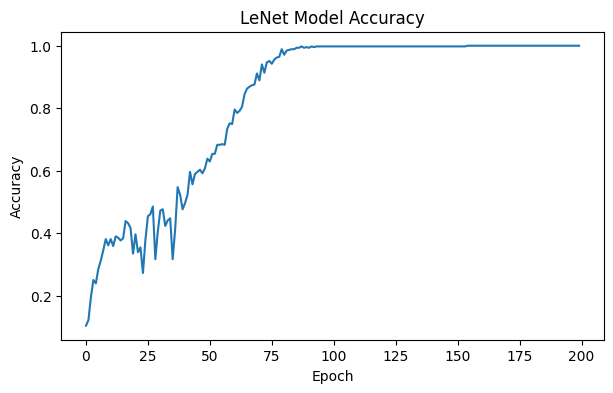

In [30]:
print_history(hist_lenet, "LeNet Model Accuracy")

### Task 1.3 - Evaluate results

Task: Compare NN with given architectures. Discuss, why results are different

In [31]:
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [32]:
net_acc = evaluate_acc(net, test_dataloader, device)
lenet_acc = evaluate_acc(lenet, test_dataloader, device)

print('Test Accuracy (NN): {:.2%}'.format(net_acc))
print('Test Accuracy (LeNet): {:.2%}'.format(lenet_acc))

Test Accuracy (NN): 92.67%
Test Accuracy (LeNet): 100.00%


In [ ]:
import random

def show_random(net, dataloader):
    dataset = dataloader.dataset

    randomIndex = random.randint(0, len(dataset) - 1)
    image, originalLabel = dataset[randomIndex]

    def get_prediction(net, input):
        input = input.permute(2, 0, 1).to(device)
        outputs = net(input)        
        _, predicted = outputs.max(1)
        return predicted
    
    predictedLabel = get_prediction(net, image)
    print('original_label ', originalLabel) 
    print('predicted_label ', predictedLabel)

    color = "green" if originalLabel == predictedLabel else "red"
    
    plt.figure()
    plt.imshow(image.numpy())
    plt.colorbar()
    plt.xlabel(class_names[predictedLabel], color = color)
    plt.show()


original_label  tensor(8)
predicted_label  tensor([8])


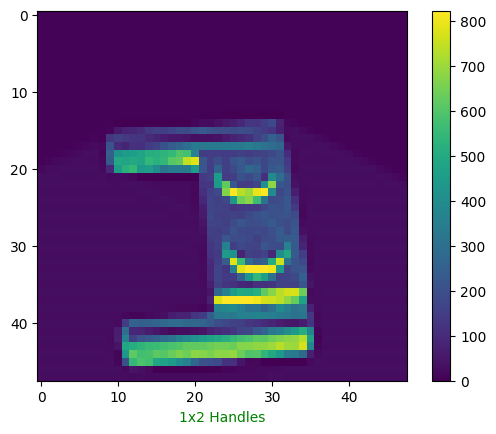

In [66]:
#nn
show_random(net, test_dataloader)